# Project: Wrangling, Analyzing and Visualizing WeRateDogs data

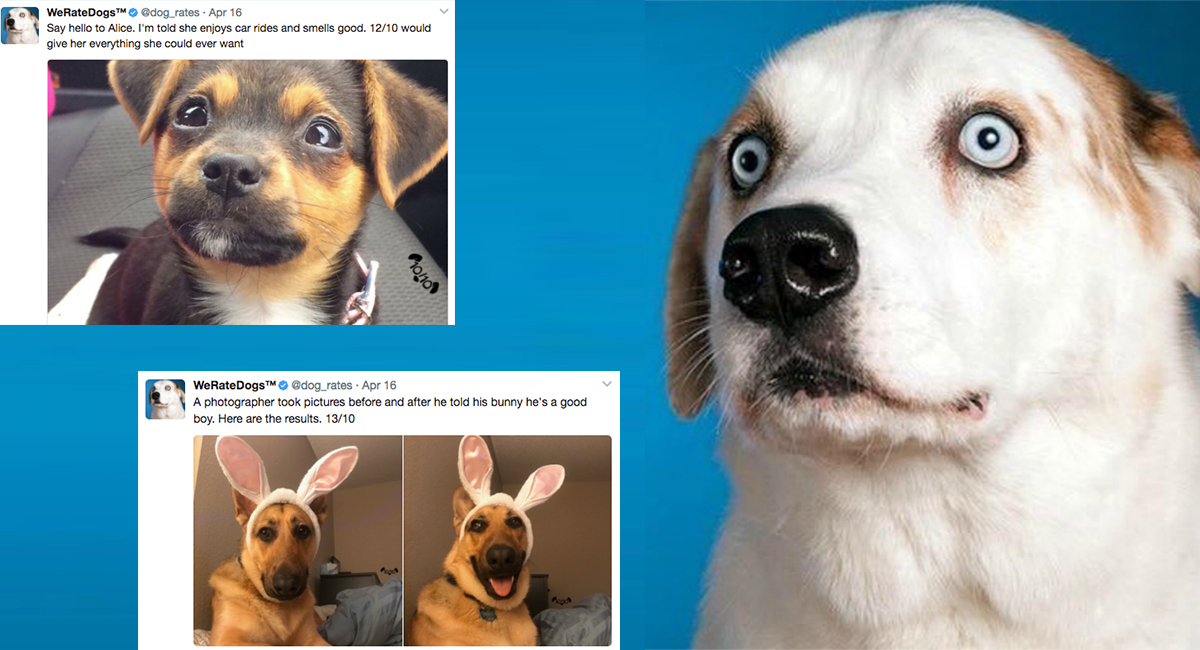

# Introduction

Real-world data rarely come clean. Using Python and its libraries, we'll be gathering data from a variety of sources and in a variety of formats, assessing its quality and tidiness, then cleaning it. This is called data wrangling. The goal is to be comfortable with wrangling data whilst documenting the wrangling effort

### About the Data

The dataset that we'll be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comments about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

### Import the Necessary Python Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import os
import re
import requests
from bs4 import BeautifulSoup
import tweepy
import config
import timeit
import datetime
from datetime import date as dt
import matplotlib.pyplot as plt


### Data Gathering (Programmatic)

#### D1: WeRateDogs Twitter archive

In [2]:
if True:
    #download the twitter archive csv file
    twitter_archive_url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv'
    response=requests.get(twitter_archive_url)
    with open('twitter_archive_enhanced.csv','wb') as mycsv:
        mycsv.write(response.content)

In [3]:
#read and preview dataset
twitter_archive=pd.read_csv('twitter_archive_enhanced.csv')
twitter_archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


#### D2: Image prediction dataset

In [4]:
if True:
    #download the image prediction tsv file
    image_predictions_url=' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
    with open('image-predictions.tsv','wb') as mytsv:
        mytsv.write(requests.get(image_predictions_url).content)

In [5]:
#read and preview dataset
image_predictions=pd.read_csv('image-predictions.tsv',sep='\t')
image_predictions.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


#### D3: Gathering data from Twitter API

In [6]:
if True:
    def notrification(x,y,z):
        x=pulled_tweet_ids
        y=tweet_ids
        z=error_log
        print('Successful pulls: {}'. format(len(x)))
        print("Tweet IDs left to complete: {}".format(len(y)-(len(x)+len(z))))
        print("Failed attempts: {}".format(len(z)))
        
    # authenticate
    auth = tweepy.OAuthHandler(config.consumer_key, config.consumer_secret)
    auth.set_access_token(config.access_token, config.access_secret)
    #get the user object for twitter
    api = tweepy.API(auth,wait_on_rate_limit=True,parser=tweepy.parsers.JSONParser())
    #get list of all tweet IDs
    tweet_ids=twitter_archive.tweet_id.sort_values().to_list()
    count=0
    pulled_tweet_ids=[]
    error_log=[]
    start = timeit.timeit()
    with open('complementary_tweet_archive.json','w') as file:
        for tweet_id in tweet_ids:
            try:
                tweet = api.get_status(tweet_id)
                json.dump(tweet,file)
                dict={
                "tweet_id":tweet['id'],
                "favorite_count":tweet['favorite_count'],
                "retweet_count":tweet['retweet_count']
                }
                pulled_tweet_ids.append(dict)
                if len(pulled_tweet_ids)%500==0:
                    #print out summary
                    notrification(x=pulled_tweet_ids,y=tweet_ids,z=error_log)
                    print(50*'-')
                
            except Exception as e:
                error={
                "tweet_id":tweet_id,
                "reason":e
                }
                error_log.append(error)
                print("{} encountered this error: ".format(tweet_id),e)
            
            

    #print out summary
    notrification(x=pulled_tweet_ids,y=tweet_ids,z=error_log)
    end = timeit.timeit()
    time_spent=(end - start)
    print("Time spent:{}secs".format(time_spent))

In [7]:
#save to local device
if True:
    api_pulled_df=pd.DataFrame(pulled_tweet_ids)
    api_pulled_df.to_csv("complementary_tweet_archive.csv")

In [8]:
api_pulled_df=pd.read_csv("complementary_tweet_archive.csv")

In [9]:
#preview data
api_pulled_df.head(3)

,Unnamed: 0,tweet_id,favorite_count,retweet_count
0,0,666020888022790149,2293,422
1,1,666029285002620928,112,39
2,2,666033412701032449,100,36


### Assessing Data
I increase the maximum column with to aid visual assessment with __pd.set_option("display.max_colwidth", None)__

The __sample()__ method also because it returns random records

#### Visually Assessing D1

In [10]:
pd.set_option("display.max_colwidth", None)

In [11]:
twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2172,669327207240699904,NaN,NaN,2015-11-25 01:30:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Just got home from college. Dis my dog. She does all my homework. Big red turd in background. 13/10 no bias at all https://t.co/6WGFp9cuj6,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669327207240699904/photo/1,13,10,None,None,None,None,None
2218,668507509523615744,NaN,NaN,2015-11-22 19:13:05 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Birmingham Quagmire named Chuk. Loves to relax and watch the game while sippin on that iced mocha. 10/10 https://t.co/HvNg9JWxFt,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668507509523615744/photo/1,10,10,a,None,None,None,None
870,761672994376806400,NaN,NaN,2016-08-05 21:19:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Ohboyohboyohboyohboyohboyohboyohboyohboyohboyohboyohboyohboyohboyohboyohboy. 10/10 for all (by happytailsresort) https://t.co/EY8kEFuzK7,NaN,NaN,NaN,https://twitter.com/dog_rates/status/761672994376806400/video/1,10,10,None,None,None,None,None
1856,675522403582218240,NaN,NaN,2015-12-12 03:47:46 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sammy. He's a Motorola Firefox. Hat under hoodie (must be a half-decent up and coming white rapper) 10/10 https://t.co/rO2zxf0OQ0,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675522403582218240/photo/1,10,10,Sammy,None,None,None,None
636,793500921481273345,NaN,NaN,2016-11-01 17:12:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Fiona. She's an extremely mediocre copilot. Very distracting. Wink makes up for all the missed turns. 12/10 https://t.co/aF5MmpvPqN,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/793500921481273345/photo/1,https://twitter.com/dog_rates/status/793500921481273345/photo/1",12,10,Fiona,None,None,None,None


>#### Observations:
>##### Quality 
>- `in_reply_stustus_id`, `in_reply_to_user_id`, `retweet_status_id`, `retweet_status_user_id` contain empty entries
>- Source column contains anchor tags rather than url or mobile feature
>- The expanded_url column contain duplicate entries and empty entries as well 
>- The `name` is not descriptive of the dogs' name
>- the name of dogs contains NaN values
>- Some ratings do not match the actual rating in text columns

>#### Tidyness
>- tweet URLs occupy the same column as the text
>- hashtags occupy the same column as the `text`
>- Dog stages i.e puppo,doggo occupy individual columns

#### Visually Assessing D2

In [12]:
image_predictions.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
164,668975677807423489,https://pbs.twimg.com/media/CUit1O1WoAEBHjj.jpg,1,basset,0.605437,True,Welsh_springer_spaniel,0.184783,True,Saint_Bernard,0.116299,True
741,687317306314240000,https://pbs.twimg.com/media/CYnXcLEUkAAIQOM.jpg,1,Shih-Tzu,0.747208,True,Maltese_dog,0.091025,True,Lhasa,0.035788,True
134,668484198282485761,https://pbs.twimg.com/media/CUbu1GAWsAEH3E-.jpg,1,standard_poodle,0.587372,True,Bedlington_terrier,0.182411,True,Afghan_hound,0.040968,True
97,667728196545200128,https://pbs.twimg.com/media/CUQ_QahUAAAVQjn.jpg,1,kuvasz,0.360159,True,golden_retriever,0.293744,True,Labrador_retriever,0.270673,True
1104,722613351520608256,https://pbs.twimg.com/media/Cgc9AjMVIAERdUA.jpg,1,Labrador_retriever,0.530915,True,golden_retriever,0.288230,True,chow,0.044854,True
575,678643457146150913,https://pbs.twimg.com/media/CWsGnyMVEAAM1Y1.jpg,1,Labrador_retriever,0.338757,True,flat-coated_retriever,0.304470,True,chest,0.093392,False
218,670073503555706880,https://pbs.twimg.com/media/CUyUSuWXIAAZKYF.jpg,1,malamute,0.601886,True,Siberian_husky,0.340106,True,Eskimo_dog,0.050041,True
946,704499785726889984,https://pbs.twimg.com/media/Ccbi0UGWoAA4fwg.jpg,1,Chihuahua,0.376541,True,Siamese_cat,0.098057,False,Labrador_retriever,0.085211,True
557,677687604918272002,https://pbs.twimg.com/media/CWehRdEWIAAySyO.jpg,1,Pembroke,0.573047,True,sunglasses,0.126758,False,golden_retriever,0.108047,True
1725,820078625395449857,https://pbs.twimg.com/media/C2GBJADWIAQvcNb.jpg,3,school_bus,0.999833,False,cab,0.000160,False,crane,0.000002,False


>#### Observation
>##### Quality
>- `p1`,`p2` and `p3` column enteries are not case standardized


>##### Tidiness
>- Not all entries of `p1_dog`,`p2_dog` and `p3_dog` columns are dogs




#### Visually Assessing D3

In [13]:
api_pulled_df.sample(10)

,Unnamed: 0,tweet_id,favorite_count,retweet_count
257,257,670727704916926465,736,314
1435,1435,756651752796094464,4703,1191
1599,1599,779834332596887552,17765,6502
2101,2101,847251039262605312,18988,3924
2108,2108,848212111729840128,15045,2721
412,412,673709992831262724,753,236
1346,1346,747594051852075008,3427,950
1158,1158,717047459982213120,5813,1742
1612,1612,781251288990355457,7927,1929
1872,1872,816450570814898180,28702,7458


>There are no obvious data quality issues observed

### Programmatically Assessing Data

#### Assessing D1

In [14]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

>#### Observation
>##### Tweets summary
>- 2355 records in all 
>- 78 records are mere replies
>- 181 records are retweets
>- Original tweets = Total records-(retweets records +reply records)
>- Only __2,096__ tweets are orignal

>##### Quality issues
>- `tweet_id` format is integer rather than string
>- `timestamp` format is object rather than type date

#### Assessing D2

In [15]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


>##### Quality
>- `tweet_id` is integer type instead of type string

#### Assessing D3

In [16]:
api_pulled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Unnamed: 0      2327 non-null   int64
 1   tweet_id        2327 non-null   int64
 2   favorite_count  2327 non-null   int64
 3   retweet_count   2327 non-null   int64
dtypes: int64(4)
memory usage: 72.8 KB


>##### Quality issue
>- `tweet_id` is type integer instead of type string

>### Assessment Note
>The three datasets gathered so far most of which were assessed visually in jupyter lab because of the wealth of advantages it has over other spreadsheet applications and further be cleaned.

>__NB:__ Data wrangling is an iterative process, we may come across other data issues as we progress. We'll not hesistate to re-assess some columns with _.value_counts(dropna=False)_ and clean the off

# Data cleaning
##### Here are the steps to the cleaning process:
1. Make a copy of each dataset
2. Address data tidiness issues
3. clean the quality issues associated with each dataset
So let's dive right into it and make copies of the datasets

In [17]:
#copy datasets
archive_tweet_clean=twitter_archive.copy()
tweeted_images_clean=image_predictions.copy()
api_pulled_clean=api_pulled_df.copy()

### Tidiness


#### 

##### The values of doggo,floofer, pupper and puppo column in the twitter_archive dataset should be in a single column

#### _Define_
Determine the stage of dog by each tweet_id simply adding `doggo`, `floofer`, `pupper`, `puppo` columns to form a single string in a new column,`dog_stage` then replace the resulting string with corresponding stage type

#### _code_

##### Summary statistics before code

In [18]:
def summarize(df,var):
    print(df[var].value_counts())
    print(30*"-")

summarize(archive_tweet_clean,"doggo")
summarize(archive_tweet_clean,'floofer')
summarize(archive_tweet_clean,"pupper")
summarize(archive_tweet_clean,"puppo")

None     2259
doggo      97
Name: doggo, dtype: int64
------------------------------
None       2346
floofer      10
Name: floofer, dtype: int64
------------------------------
None      2099
pupper     257
Name: pupper, dtype: int64
------------------------------
None     2326
puppo      30
Name: puppo, dtype: int64
------------------------------


In [19]:
# Condense the value of doggo,floofer, pupper and puppo columns to a single column
archive_tweet_clean['dog_stage']=archive_tweet_clean["doggo"]+archive_tweet_clean['floofer']+archive_tweet_clean["pupper"]+archive_tweet_clean["puppo"]
summarize(archive_tweet_clean,'dog_stage')

NoneNoneNoneNone        1976
NoneNonepupperNone       245
doggoNoneNoneNone         83
NoneNoneNonepuppo         29
doggoNonepupperNone       12
NoneflooferNoneNone        9
doggoNoneNonepuppo         1
doggoflooferNoneNone       1
Name: dog_stage, dtype: int64
------------------------------


In [20]:
dict={'NoneNoneNoneNone':"unclassified",
 'NoneNonepupperNone':"pupper",
 'doggoNoneNoneNone':'doggo',
 'NoneNoneNonepuppo':"puppo",
 'doggoNonepupperNone':"doggo_pupper",
 'NoneflooferNoneNone':"floofer",
 'doggoNoneNonepuppo':"doggo_puppo",
 'doggoflooferNoneNone':"doggo_floofer"}
archive_tweet_clean['dog_stage'].replace(dict,inplace=True)

##### Further investigation
Let's drill down further, perhaps there is something else underneath that needs cleaning. We'll begin by showing the summary after the initial cleaning process
##### Summary statistics after:

In [21]:
#summarize
summarize(archive_tweet_clean,"dog_stage")

unclassified     1976
pupper            245
doggo              83
puppo              29
doggo_pupper       12
floofer             9
doggo_puppo         1
doggo_floofer       1
Name: dog_stage, dtype: int64
------------------------------


> Some dogs appear to fall in between "doggo"  and others dog stages, i.e `doggo_pupper`,`doggo_puppo` and doggo_floofer. We'll begin examining the dogs in these categories to ensure propper cleaning.

###### __doggo_floofer stage__:

> We have displayed the row of the data with doggo_floofer below. Upon examining the text column we can conclude that the author knew for certain that his god is a Floofer. So we'll change the dog stage to Floor 

In [22]:
def display(df,dog_stage_type):
    ''' 
    the function displays the rows of a  specific
    column type present in the data frame
    '''
    
    pd.set_option("display.max_colwidth", None)
    context='dog_stage==@dog_stage_type'
    return (df.query(context))
    
    
display(archive_tweet_clean,"doggo_floofer")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",11,10,None,doggo,floofer,None,None,doggo_floofer


>__Author's tweet__:
"`At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl.` Amateurs would confuse the two. 11/10 only send dogs"
>- Hence, the dog stage is a __Floofer__

###### __doggo_puppo__:

In [23]:
display(archive_tweet_clean,"doggo_puppo")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453814013952/photo/1,13,10,None,doggo,None,None,puppo,doggo_puppo


>__Author's tweet__:
"`Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda`. 13/10 would keep the planet habitable fo"
>- Hence, the dog stage is a __Puppo__

###### doggo_pupper:

In [24]:
display(archive_tweet_clean,"doggo_pupper")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686764523521/video/1,13,10,Dido,doggo,None,pupper,None,doggo_pupper
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460588765185/photo/1,12,10,None,doggo,None,pupper,None,doggo_pupper
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048156610565/photo/1,11,10,None,doggo,None,pupper,None,doggo_pupper
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/801115127852503040/photo/1,https://twitter.com/dog_rates/status/801115127852503040/photo/1",12,10,Bones,doggo,None,pupper,None,doggo_pupper
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/785639753186217984/photo/1,https://twitter.com/dog_rates/status/785639753186217984/photo/1",10,10,Pinot,doggo,None,pupper,None,doggo_pupper
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>","Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None,doggo_pupper
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,"https://twitter.com/dog_rates/status/733109485275860992/photo/1,https://twitter.com/dog_rates/status/733109485275860992/photo/1",12,10,None,doggo,None,pupper,None,doggo_pupper
822,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,"https://twitter.com/dog_rates/status/741067306818797568/photo/1,https://twitter.com/dog_rates/status/741067306818797568/photo/1",12,10,just,doggo,None,pupper,None,doggo_pupper
889,759793422261743616,NaN,NaN,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/

>__Tweet assessment__:
>- tweet_id 855851453814013952 is a __Puppo__ #hint: `Here's a puppo participating in the #ScienceMarch`
>- tweet_id 802265048156610565 are two dogs, a doggo and a pupper rated together 12/10. #hint: follow link to see picture https://t.co/ANBpEYHaho
>- tweet_id 802265048156610565 are two dogs, a doggo and a pupper rated together 12/10. #hint: follow link to see picture https://t.co/9IxWAXFqze
>- tweet_id 801115127852503040 from visual assessment is a __Pupper__. #hint: follow link to see picture https://t.co/55Dqe0SJNj
>- tweet_id 785639753186217984 is a  __doggo__. #hint:`This is Pinot. He's a sophisticated doggo`. You can tell by the hat. Also pointier than your average pupper
>- tweet_id 781308096455073793 are two dogs, a doggo and a pupper rated together 12/10. #hint: follow link to see picture https://t.co/WQvcPEpH2u
>- tweet_id 775898661951791106 are two dogs, a doggo and a pupper rated together. #hint: RT @dog_rates: `Like father (doggo), like son (pupper).`  
>- tweet_id 770093767776997377 are two dogs, a doggo and a pupper rated together. #hint:  This is just downright precious af. 12/10 for `both pupper and doggo` 
>- tweet_id 759793422261743616 are two dogs, a doggo and a pupper rated together. #hint: RT @dog_rates: `Like father (doggo), like son (pupper).` 
>- tweet_id 759793422261743616 are two dogs, a doggo and a pupper rated together. #hint: Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time.` 
>- tweet_id 751583847268179968 is is a  __doggo__. #hint: Author updated his tweet even though he wasn't sure initially.`, https://twitter.com/dog_rates/status/751587816937758720 
>- tweet_id 741067306818797568 are two dogs, a doggo and a pupper rated together. #hint:...`both pupper and doggo in them` https://t.co/o5J479bZUC
>- tweet_id 733109485275860992 are two dogs, a doggo and a pupper rated together. #hint: RT @dog_rates: `Like father (doggo), like son (pupper).` 


#### Some dog stages are wrongly placed

####  _Define__ 
Correct missclassified dog stages, `puppo`,`floofler` and `doggo` by replacing correct dog stage with matching tweet IDs while others remain the same

#### _Code_

In [25]:
def replace_stage(df,dog_stage,tweet_ids):
    ''' function replaces dog stage type
        and test wether change has been effected
    '''
    for tweep_id in tweet_ids:
        df.loc[df["tweet_id"] == tweep_id, 'dog_stage'] =dog_stage
    print(60*'-')
    print(10*" "+"*Confirm cell has change to {}".format(dog_stage))
    print(60*'-'+"\n")
    return df.loc[df["tweet_id"] == tweep_id]

In [26]:
#create list of tweet IDs to be replaced
puppo_ids=[855851453814013952,855851453814013952]
floofer_id=[854010172552949760]
doggo_ids=[785639753186217984,751583847268179968]


In [27]:
replace_stage(archive_tweet_clean,"puppo",puppo_ids)

------------------------------------------------------------
          *Confirm cell has change to puppo
------------------------------------------------------------



,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453814013952/photo/1,13,10,None,doggo,None,None,puppo,puppo


In [28]:
replace_stage(archive_tweet_clean,"floofer",floofer_id)

------------------------------------------------------------
          *Confirm cell has change to floofer
------------------------------------------------------------



,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",11,10,None,doggo,floofer,None,None,floofer


In [29]:
replace_stage(archive_tweet_clean,"doggo",doggo_ids)

------------------------------------------------------------
          *Confirm cell has change to doggo
------------------------------------------------------------



,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage
956,751583847268179968,NaN,NaN,2016-07-09 01:08:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,NaN,NaN,NaN,https://twitter.com/dog_rates/status/751583847268179968/photo/1,5,10,None,doggo,None,pupper,None,doggo


#### _Test_
- doggo_pupper is not expected to be seen
- doggo_floofer is not expected to be seen
- doggo_puppo  is the only combination expected

__N:B__ doggo_puppo will be tolerated in this analysis even though two different sizes of dog pictures were posted because our major focus is analyzing tweets.

In [30]:
archive_tweet_clean.dog_stage.value_counts()

unclassified    1976
pupper           245
doggo             85
puppo             30
floofer           10
doggo_pupper      10
Name: dog_stage, dtype: int64

#### Tweet URL in text column should be in a separate column

#### _Define_
Extract all the url in `text` column to new column and strip the text off the url
##### Code

In [31]:
#extract url from text
url_extract=archive_tweet_clean['text'].str.extract(r'(http[s]?.+)')
#add new column to data frame
archive_tweet_clean['text']=archive_tweet_clean['text'].str.replace(r'(http[s]?.+)',"",regex=True)
archive_tweet_clean['tweet_url']=url_extract


#### _Test_

In [32]:
#confirm changes up to the head of data frame
archive_tweet_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage,tweet_url
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,unclassified,https://t.co/MgUWQ76dJU
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None,unclassified,https://t.co/0Xxu71qeIV
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None,unclassified,https://t.co/wUnZnhtVJB
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None,unclassified,https://t.co/tD36da7qLQ
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None,unclassified,https://t.co/AtUZn91f7f


In [33]:
#confirm changes up to the tail of data frame
archive_tweet_clean.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage,tweet_url
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None,unclassified,https://t.co/4B7cOc1EDq
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None,unclassified,https://t.co/DWnyCjf2mx
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None,unclassified,https://t.co/y671yMhoiR
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None,unclassified,https://t.co/r7mOb2m0UI
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8,10,None,None,None,None,None,unclassified,https://t.co/BLDqew2Ijj


#### _Define_
##### Extract hashtags from text column to a new column,`hashtag` and fill empty cells with 'unhashtaged'
#### _Code_

In [34]:
hashtag_extract=archive_tweet_clean['text'].str.extract(r'(#\w+)')
archive_tweet_clean['hashtag']=hashtag_extract
# =twitter_archive[hashtag_extract]
archive_tweet_clean['text']=archive_tweet_clean['text'].replace(r'(#\w+)'," ",regex=True)
archive_tweet_clean['hashtag'].fillna("unhashtaged",inplace=True)


#### _Test_

In [35]:
#confirm changes up to head of data frame
archive_tweet_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage,tweet_url,hashtag
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,unclassified,https://t.co/MgUWQ76dJU,unhashtaged
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None,unclassified,https://t.co/0Xxu71qeIV,unhashtaged
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None,unclassified,https://t.co/wUnZnhtVJB,unhashtaged
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None,unclassified,https://t.co/tD36da7qLQ,unhashtaged
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None,unclassified,https://t.co/AtUZn91f7f,#BarkWeek


In [36]:
#confirm changes up to the tail of data framarchive_tweet_clean
archive_tweet_clean.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage,tweet_url,hashtag
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None,unclassified,https://t.co/4B7cOc1EDq,unhashtaged
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None,unclassified,https://t.co/DWnyCjf2mx,unhashtaged
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None,unclassified,https://t.co/y671yMhoiR,unhashtaged
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None,unclassified,https://t.co/r7mOb2m0UI,unhashtaged
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8,10,None,None,None,None,None,unclassified,https://t.co/BLDqew2Ijj,unhashtaged


## Quality

### Records of `twitter_archive` daatset contain retweets and reply records

#### _Define_
- Filter all records where `retweet_status_id`and `in_reply_to_status_id` are not empty

#### _Code_

In [37]:
#select records where there are empty entries in retweets and reply
empty_retweet=archive_tweet_clean['retweeted_status_id'].isnull()
empty_reply=archive_tweet_clean['in_reply_to_status_id'].isnull()
archive_tweet_clean=archive_tweet_clean[empty_retweet & empty_reply]

#### _Test_

In [38]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

>#### summary
>- 2097 total tweets
>- 0 retweets and replies
>- drop all retweet and and reply related columns as they are not needed anymore

### Drop the following columns:  
`in_reply_to_status_id`,`in_reply_to_user_id`,`expanded_urls`,`retweeted_status_id`,`retweeted_status_user_id`,
`retweeted_status_timestamp`,`pupper`,`doggo`,`puppo`,`floofer`
#### _Define_
Filter out the above mentioned columns

#### _Code_

In [39]:
archive_tweet_clean=archive_tweet_clean[["tweet_id","timestamp","text","source","tweet_url","hashtag","rating_numerator","rating_denominator","name","dog_stage"]]

#### _Test_

In [40]:
#confirm changes up to the tail of data frame
archive_tweet_clean.sample(6)

,tweet_id,timestamp,text,source,tweet_url,hashtag,rating_numerator,rating_denominator,name,dog_stage
457,818145370475810820,2017-01-08 17:20:31 +0000,This is Autumn. Her favorite toy is a cheeseburger. She takes it everywhere. 11/10,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",https://t.co/JlPug12E5Z,unhashtaged,11,10,Autumn,unclassified
1775,678021115718029313,2015-12-19 01:16:45 +0000,This is Reese. He likes holding hands. 12/10,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",https://t.co/cbLroGCbmh,unhashtaged,12,10,Reese,unclassified
819,770655142660169732,2016-08-30 16:11:18 +0000,We only rate dogs. Pls stop sending in non-canines like this Arctic Floof Kangaroo. This is very frustrating. 11/10,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",https://t.co/qlUDuPoE3d,unhashtaged,11,10,very,unclassified
545,805826884734976000,2016-12-05 17:31:15 +0000,This is Duke. He is not a fan of the pupporazzi. 12/10,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",https://t.co/SgpBVYIL18,unhashtaged,12,10,Duke,unclassified
1568,687818504314159109,2016-01-15 02:08:05 +0000,With great pupper comes great responsibility. 12/10,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",https://t.co/hK6xB042EP,unhashtaged,12,10,None,pupper
279,839990271299457024,2017-03-10 00:04:21 +0000,Meet Sojourner. His nose is a Fibonacci Spiral. Legendary af. 13/10 we must protect him at all costs,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",https://t.co/r7W1NbkOtr,unhashtaged,13,10,Sojourner,unclassified


### Replace source column with only texts within the anchor tags

### _Define_

##### Substitute anchor tag contents for strings in source column using BeautifulSoup and pandas 

#### Code

###### Before:

In [41]:
archive_tweet_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1964
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [42]:
anchor_tag_contents=[]
#collect contents from anchor tags
for link in archive_tweet_clean['source']:
    soup=BeautifulSoup(link)
    row=soup.find('a').text
    anchor_tag_contents.append(row)
 #convert to pandas series   
twitter_feature=pd.Series(anchor_tag_contents)

#substute text in source for text in tags
archive_tweet_clean.loc[:,"source"]=anchor_tag_contents

#### Test

###### After:

In [43]:
# confirm changes
archive_tweet_clean.source.value_counts()

Twitter for iPhone     1964
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

### Time format is object rather than type date

In [44]:
archive_tweet_clean.timestamp.info()

<class 'pandas.core.series.Series'>
Int64Index: 2097 entries, 0 to 2355
Series name: timestamp
Non-Null Count  Dtype 
--------------  ----- 
2097 non-null   object
dtypes: object(1)
memory usage: 32.8+ KB


#### _Define_

#### Convert `timestamp` from obeject to type datetime. Having the date and time in a separate column is very okay for clearity even though it is not a tidiness issue
- create a column date
- create another column time
- drop column timestamp

#### _Code_

In [45]:
#convert to datetime
archive_tweet_clean['timestamp']=pd.to_datetime(archive_tweet_clean['timestamp'])
#insert a new column date
archive_tweet_clean.insert(1,"date",archive_tweet_clean['timestamp'].dt.date)
#insert a new column time
archive_tweet_clean.insert(2,"time",archive_tweet_clean['timestamp'].dt.time)
#drop timestamp column
archive_tweet_clean.drop('timestamp',axis=1,inplace=True)

#### _Test_

In [46]:
archive_tweet_clean.head()

,tweet_id,date,time,text,source,tweet_url,hashtag,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,2017-08-01,16:23:56,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,Twitter for iPhone,https://t.co/MgUWQ76dJU,unhashtaged,13,10,Phineas,unclassified
1,892177421306343426,2017-08-01,00:17:27,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",Twitter for iPhone,https://t.co/0Xxu71qeIV,unhashtaged,13,10,Tilly,unclassified
2,891815181378084864,2017-07-31,00:18:03,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,Twitter for iPhone,https://t.co/wUnZnhtVJB,unhashtaged,12,10,Archie,unclassified
3,891689557279858688,2017-07-30,15:58:51,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,Twitter for iPhone,https://t.co/tD36da7qLQ,unhashtaged,13,10,Darla,unclassified
4,891327558926688256,2017-07-29,16:00:24,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10",Twitter for iPhone,https://t.co/AtUZn91f7f,#BarkWeek,12,10,Franklin,unclassified


## some the rating_numerator and rating_denominator of some tweet ids are incorrect

In [47]:
archive_tweet_clean.query("tweet_id==722974582966214656")

,tweet_id,date,time,text,source,tweet_url,hashtag,rating_numerator,rating_denominator,name,dog_stage
1165,722974582966214656,2016-04-21,02:25:47,Happy 4/20 from the squad! 13/10 for all,Twitter for iPhone,https://t.co/eV1diwds8a,unhashtaged,4,20,None,unclassified


>##### Wrongly matched rating score
> The text reads,"13/10 for all."

#### _Define_

#### Use regex to extract ratings whose denominator equals 10 since majority were rated /10 and then investigate the empty cells and provide further cleaning

#### _Code_

In [48]:
#extract allscore with denominator = 10
archive_tweet_clean[["score","temp_score"]]=archive_tweet_clean['text'].str.extract(r'(\d+(\.\d*)?\/[1][0])')
empty_cells=len(archive_tweet_clean[archive_tweet_clean['score'].isnull()]['score'])
print(60*"-")
print("The total number of columns without a matching score is: {}".format(empty_cells))
archive_tweet_clean.score.value_counts(dropna=False)


------------------------------------------------------------
The total number of columns without a matching score is: 12


12/10       486
10/10       437
11/10       414
13/10       288
9/10        153
8/10         98
7/10         51
14/10        39
5/10         33
6/10         32
3/10         19
4/10         15
NaN          12
2/10          9
1/10          4
11.26/10      1
1776/10       1
11.27/10      1
9.75/10       1
0/10          1
13.5/10       1
420/10        1
Name: score, dtype: int64

>#### observation
The number of cells without a match is __16__ in total

> __Next__ we extract the score with denominator >10. A match will replace the empty cells, otherwise it remains empty


#### Filling the resulting null values in `score` column
Notice that a rating with denomination= 10 was extracted from the text first. The reason is that from visual assessment denominator of 10 is the most frequent. Besides, see what [Wikepedia](https://en.wikipedia.org/wiki/WeRateDogs#:~:text=WeRateDogs%20asks%20people%20to%20send,posted%20on%20Instagram%20and%20Facebook.) has to say about us @WeRateDogs-"WeRateDogs asks people to send photos of their dogs, then tweets selected photos rating and humorous comment. `Dogs are rated on a scale of one to ten`, but are invariably given ratings over the maximum, such as "13/10"."

##### steps:
1. populate the newly created column above, `temp_score` with values in the `score` column such that one is a copy of the other
2. create another column, `nan_score`. it will contain extracts from the `text` column where the regex accommodates denominator above 10
3. Now select all rows in `nan_score` where the score is NaN (isnull()) and store it in a variable
4. substitute null values in the `score` column for extracted ratings in `nan_score`
5. inspect data further both visually and programmatic
6. commit necessary changes
7. split score into half, numerator and denominator in a separate column

##### _code_

In [49]:
# make a copy of rating
archive_tweet_clean['temp_score']=archive_tweet_clean['score']

In [50]:
#extract rating from text
archive_tweet_clean[["nan_score"]]=archive_tweet_clean['text'].str.extract(r'(\d+\/\d{2,3})')

In [51]:
#select nan_score where score is null 
new_extracts=archive_tweet_clean.loc[archive_tweet_clean['score'].isnull(),"nan_score"]
new_extracts

433       84/70
516         NaN
902     165/150
1120    204/170
1228      99/90
1254      80/80
1274      45/50
1351      60/50
1433      44/40
1635    121/110
1779    144/120
1843      88/80
Name: nan_score, dtype: object

In [52]:
#replace null values
archive_tweet_clean.loc[archive_tweet_clean['temp_score'].isnull(),'score']=new_extracts
archive_tweet_clean.drop(['nan_score','temp_score'],axis=1,inplace=True)

In [53]:
archive_tweet_clean.score.value_counts()

12/10       486
10/10       437
11/10       414
13/10       288
9/10        153
8/10         98
7/10         51
14/10        39
5/10         33
6/10         32
3/10         19
4/10         15
2/10          9
1/10          4
11.27/10      1
9.75/10       1
88/80         1
144/120       1
11.26/10      1
121/110       1
44/40         1
60/50         1
45/50         1
80/80         1
99/90         1
204/170       1
1776/10       1
165/150       1
13.5/10       1
0/10          1
84/70         1
420/10        1
Name: score, dtype: int64

> Majority of the rating less than value count 3 needs a proper investigation to ascertain the correct score. Visually in the sense to make conversion with full text. The context will matter as we can see.

In [54]:
def check(var):
    x=archive_tweet_clean.query('score==@var')
    return x

In [55]:
archive_tweet_clean[archive_tweet_clean["rating_numerator"]>15]

,tweet_id,date,time,text,source,tweet_url,hashtag,rating_numerator,rating_denominator,name,dog_stage,score
433,820690176645140481,2017-01-15,17:52:40,The floofs have been released I repeat the floofs have been released. 84/70,Twitter for iPhone,https://t.co/NIYC820tmd,unhashtaged,84,70,None,unclassified,84/70
516,810984652412424192,2016-12-19,23:06:23,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\n,Twitter for iPhone,https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,unhashtaged,24,7,Sam,unclassified,NaN
695,786709082849828864,2016-10-13,23:23:56,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",Twitter for iPhone,https://t.co/yBO5wuqaPS,unhashtaged,75,10,Logan,unclassified,9.75/10
763,778027034220126208,2016-09-20,00:24:34,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,Twitter for iPhone,https://t.co/QFaUiIHxHq,unhashtaged,27,10,Sophie,pupper,11.27/10
902,758467244762497024,2016-07-28,01:00:57,Why does this never happen at my front door... 165/150,Twitter for iPhone,https://t.co/HmwrdfEfUE,unhashtaged,165,150,None,unclassified,165/150
979,749981277374128128,2016-07-04,15:00:45,This is Atticus. He's quite simply America af. 1776/10,TweetDeck,https://t.co/GRXwMxLBkh,unhashtaged,1776,10,Atticus,unclassified,1776/10
1120,731156023742988288,2016-05-13,16:15:54,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once,Twitter for iPhone,https://t.co/yGQI3He3xv,unhashtaged,204,170,this,unclassified,204/170
1202,716439118184652801,2016-04-03,01:36:11,This is Bluebert. He just saw that both match ups are split 50/50. Amazed af. 11/10,Twitter for iPhone,https://t.co/Kky1DPG4iq,#FinalFur,50,50,Bluebert,unclassified,11/10
1228,713900603437621249,2016-03-27,01:29:02,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody,Twitter for iPhone,https://t.co/mpvaVxKmc1,unhashtaged,99,90,None,unclassified,99/90
1254,710658690886586372,2016-03-18,02:46:49,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80,Twitter for iPhone,https://t.co/0eb7R1Om12,unhashtaged,80,80,None,unclassified,80/80


>#### In contex:
> - The ranking for tweet_id 881633300179243008 is incorrect while others match correctly. Hence we change it manually

> See text. It reads, "@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like `13/10s`"
##### _code_

In [56]:
#select score with specific id and replace value
archive_tweet_clean.loc[archive_tweet_clean["tweet_id"]==881633300179243008,"score"]="13/10"

##### Test

In [57]:
# confirm value change
archive_tweet_clean.loc[archive_tweet_clean["tweet_id"]==881633300179243008,"score"]

Series([], Name: score, dtype: object)

#### investigate rating denominator

In [58]:
archive_tweet_clean[archive_tweet_clean["rating_denominator"]>10]

,tweet_id,date,time,text,source,tweet_url,hashtag,rating_numerator,rating_denominator,name,dog_stage,score
433,820690176645140481,2017-01-15,17:52:40,The floofs have been released I repeat the floofs have been released. 84/70,Twitter for iPhone,https://t.co/NIYC820tmd,unhashtaged,84,70,None,unclassified,84/70
902,758467244762497024,2016-07-28,01:00:57,Why does this never happen at my front door... 165/150,Twitter for iPhone,https://t.co/HmwrdfEfUE,unhashtaged,165,150,None,unclassified,165/150
1068,740373189193256964,2016-06-08,02:41:38,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP",Twitter for iPhone,https://t.co/XAVDNDaVgQ,unhashtaged,9,11,None,unclassified,14/10
1120,731156023742988288,2016-05-13,16:15:54,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once,Twitter for iPhone,https://t.co/yGQI3He3xv,unhashtaged,204,170,this,unclassified,204/170
1165,722974582966214656,2016-04-21,02:25:47,Happy 4/20 from the squad! 13/10 for all,Twitter for iPhone,https://t.co/eV1diwds8a,unhashtaged,4,20,None,unclassified,13/10
1202,716439118184652801,2016-04-03,01:36:11,This is Bluebert. He just saw that both match ups are split 50/50. Amazed af. 11/10,Twitter for iPhone,https://t.co/Kky1DPG4iq,#FinalFur,50,50,Bluebert,unclassified,11/10
1228,713900603437621249,2016-03-27,01:29:02,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody,Twitter for iPhone,https://t.co/mpvaVxKmc1,unhashtaged,99,90,None,unclassified,99/90
1254,710658690886586372,2016-03-18,02:46:49,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80,Twitter for iPhone,https://t.co/0eb7R1Om12,unhashtaged,80,80,None,unclassified,80/80
1274,709198395643068416,2016-03-14,02:04:08,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once",Twitter for iPhone,https://t.co/sedre1ivTK,unhashtaged,45,50,None,unclassified,45/50
1351,704054845121142784,2016-02-28,21:25:30,Here is a whole flock of puppers. 60/50 I'll take the lot,Twitter for iPhone,https://t.co/9dpcw6MdWa,unhashtaged,60,50,a,unclassified,60/50


>#### In context:
>- Analysing the tweets, all scores above 10 seem to have been awarded delibrately
>- They will be left as they are

 ###### Now set the correct values of rating_numerator and rating_denominator to the one that matches the score

In [59]:
#split score column into different columns
temp_df=archive_tweet_clean['score'].str.split("/",expand=True)

#replace column values with new score
archive_tweet_clean.loc[:,"rating_numerator"]=temp_df[0]
archive_tweet_clean.loc[:,"rating_denominator"]=temp_df[1]
#drop column
archive_tweet_clean.drop('score', axis=1,inplace=True)

#### _Test_

In [60]:
archive_tweet_clean.head()

,tweet_id,date,time,text,source,tweet_url,hashtag,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,2017-08-01,16:23:56,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,Twitter for iPhone,https://t.co/MgUWQ76dJU,unhashtaged,13,10,Phineas,unclassified
1,892177421306343426,2017-08-01,00:17:27,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",Twitter for iPhone,https://t.co/0Xxu71qeIV,unhashtaged,13,10,Tilly,unclassified
2,891815181378084864,2017-07-31,00:18:03,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,Twitter for iPhone,https://t.co/wUnZnhtVJB,unhashtaged,12,10,Archie,unclassified
3,891689557279858688,2017-07-30,15:58:51,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,Twitter for iPhone,https://t.co/tD36da7qLQ,unhashtaged,13,10,Darla,unclassified
4,891327558926688256,2017-07-29,16:00:24,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10",Twitter for iPhone,https://t.co/AtUZn91f7f,#BarkWeek,12,10,Franklin,unclassified


##### Some cells in column `name` contain article "a" instead of full actual name

#### _Define_

#### Extract possible name from column text and replace article 'a' in name column with the newly found name in text

#### _code_

In [61]:
archive_tweet_clean.query('name=="a"')

,tweet_id,date,time,text,source,tweet_url,hashtag,rating_numerator,rating_denominator,name,dog_stage
56,881536004380872706,2017-07-02,15:32:16,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow),Twitter for iPhone,https://t.co/ghXBIIeQZF,unhashtaged,14,10,a,pupper
649,792913359805018113,2016-10-31,02:17:31,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest,Twitter for iPhone,https://t.co/LRyMrU7Wfq,unhashtaged,13,10,a,unclassified
801,772581559778025472,2016-09-04,23:46:12,Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10,Twitter for iPhone,https://t.co/8lpAGaZRFn,unhashtaged,10,10,a,unclassified
1002,747885874273214464,2016-06-28,20:14:22,This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10,Twitter for iPhone,https://t.co/TGenMeXreW,unhashtaged,8,10,a,unclassified
1004,747816857231626240,2016-06-28,15:40:07,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk,Twitter for iPhone,https://t.co/L3U0j14N5R,unhashtaged,4,10,a,unclassified
1017,746872823977771008,2016-06-26,01:08:52,This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10,Twitter for iPhone,https://t.co/9e48aPrBm2,unhashtaged,11,10,a,unclassified
1049,743222593470234624,2016-06-15,23:24:09,This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately,Twitter for iPhone,https://t.co/xOBKCdpzaa,unhashtaged,12,10,a,pupper
1193,717537687239008257,2016-04-06,02:21:30,People please. This is a Deadly Mediterranean Plop T-Rex. We only rate dogs. Only send in dogs. Thanks you... 11/10,Twitter for iPhone,https://t.co/2ATDsgHD4n,unhashtaged,11,10,a,unclassified
1207,715733265223708672,2016-04-01,02:51:22,This is a taco. We only rate dogs. Please only send in dogs. Dogs are what we rate. Not tacos. Thank you... 10/10,Twitter for iPhone,https://t.co/cxl6xGY8B9,unhashtaged,10,10,a,unclassified
1340,704859558691414016,2016-03-02,02:43:09,Here is a heartbreaking scene of an incredible pupper being laid to rest. 10/10 RIP pupper,Twitter for iPhone,https://t.co/81mvJ0rGRu,unhashtaged,10,10,a,pupper


> ### Observations

>- Most dogs having their name in the text have the word "named" before the dog's name

>- We can use regex to extract a dog's name where the word "named" or name is mentioned in the text

###### Select all where name is 'a'

In [62]:
named_a=archive_tweet_clean.query("name=='a'")
named_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 56 to 2354
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            55 non-null     int64 
 1   date                55 non-null     object
 2   time                55 non-null     object
 3   text                55 non-null     object
 4   source              55 non-null     object
 5   tweet_url           55 non-null     object
 6   hashtag             55 non-null     object
 7   rating_numerator    55 non-null     object
 8   rating_denominator  55 non-null     object
 9   name                55 non-null     object
 10  dog_stage           55 non-null     object
dtypes: int64(1), object(10)
memory usage: 5.2+ KB


> #### Names of 55 dogs were wrongly captured as 'a'

>__Next__ we'll extract possible names from `text` column

In [63]:
# extract text after 'named'
archive_tweet_clean["named"]=archive_tweet_clean['text'].str.extract(r'named (\w+)')

In [64]:
named_a=archive_tweet_clean.query("name=='a'")
named_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 56 to 2354
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            55 non-null     int64 
 1   date                55 non-null     object
 2   time                55 non-null     object
 3   text                55 non-null     object
 4   source              55 non-null     object
 5   tweet_url           55 non-null     object
 6   hashtag             55 non-null     object
 7   rating_numerator    55 non-null     object
 8   rating_denominator  55 non-null     object
 9   name                55 non-null     object
 10  dog_stage           55 non-null     object
 11  named               19 non-null     object
dtypes: int64(1), object(11)
memory usage: 5.6+ KB


> ##### Of the 55 dogs, only 19 names were found in their corresponding `text` column
> See extract in column `named`

In [65]:
named_a['named'].value_counts(dropna=False)

NaN          36
Wylie         1
Octaviath     1
Pepe          1
Kohl          1
Klint         1
Jessiga       1
Cheryl        1
Alfonso       1
Chuk          1
Leroi         1
Alfredo       1
Alphred       1
Hemry         1
Cherokee      1
Spork         1
Rufus         1
Jacob         1
Kip           1
Johm          1
Name: named, dtype: int64

In [66]:
#make a copy of dog's name column
archive_tweet_clean['dog_name']=archive_tweet_clean['name']

In [67]:

archive_tweet_clean.loc[archive_tweet_clean["name"]=='a',"dog_name"]=named_a['named']

### test

In [68]:
archive_tweet_clean.query("name=='a'")

,tweet_id,date,time,text,source,tweet_url,hashtag,rating_numerator,rating_denominator,name,dog_stage,named,dog_name
56,881536004380872706,2017-07-02,15:32:16,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow),Twitter for iPhone,https://t.co/ghXBIIeQZF,unhashtaged,14,10,a,pupper,NaN,NaN
649,792913359805018113,2016-10-31,02:17:31,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest,Twitter for iPhone,https://t.co/LRyMrU7Wfq,unhashtaged,13,10,a,unclassified,NaN,NaN
801,772581559778025472,2016-09-04,23:46:12,Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10,Twitter for iPhone,https://t.co/8lpAGaZRFn,unhashtaged,10,10,a,unclassified,NaN,NaN
1002,747885874273214464,2016-06-28,20:14:22,This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10,Twitter for iPhone,https://t.co/TGenMeXreW,unhashtaged,8,10,a,unclassified,NaN,NaN
1004,747816857231626240,2016-06-28,15:40:07,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk,Twitter for iPhone,https://t.co/L3U0j14N5R,unhashtaged,4,10,a,unclassified,NaN,NaN
1017,746872823977771008,2016-06-26,01:08:52,This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10,Twitter for iPhone,https://t.co/9e48aPrBm2,unhashtaged,11,10,a,unclassified,NaN,NaN
1049,743222593470234624,2016-06-15,23:24:09,This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately,Twitter for iPhone,https://t.co/xOBKCdpzaa,unhashtaged,12,10,a,pupper,NaN,NaN
1193,717537687239008257,2016-04-06,02:21:30,People please. This is a Deadly Mediterranean Plop T-Rex. We only rate dogs. Only send in dogs. Thanks you... 11/10,Twitter for iPhone,https://t.co/2ATDsgHD4n,unhashtaged,11,10,a,unclassified,NaN,NaN
1207,715733265223708672,2016-04-01,02:51:22,This is a taco. We only rate dogs. Please only send in dogs. Dogs are what we rate. Not tacos. Thank you... 10/10,Twitter for iPhone,https://t.co/cxl6xGY8B9,unhashtaged,10,10,a,unclassified,NaN,NaN
1340,704859558691414016,2016-03-02,02:43:09,Here is a heartbreaking scene of an incredible pupper being laid to rest. 10/10 RIP pupper,Twitter for iPhone,https://t.co/81mvJ0rGRu,unhashtaged,10,10,a,pupper,NaN,NaN


>### Observation:
The above output is a filtered data frame where column `name` has an article "a". Visually comparing column `name` and the `dog_name` column one can see that extracted names from the text have replaced "a" in some cells in `dog_names`. Recall that `dog_name` column was initially a copy of column `name` and so because of substituting the name extract including empty cells (NaN) for "a" will force every cell without a name match to be NaN. In other words, in a row where a match is not found, NaN replaces 'a' in that case 



### A step further:
Since the regex wasn't targeted to extract all possible names, we extract another regex formula. This time we're looking for names that fit into such a sentence as "name is _____. " For example, one tweet reads, "This is a Dasani Kingfisher from Maine. __` His name is Daryl`__. Daryl doesn't like being swallowed by a panda. 8/1." It is possible there are others like that

So now, we are going to select all empty cells in column `name`, and search their respective tweets in column `text` for a match. If there is a match we then select all empty cells in column `dog_name` and set their values to those extracted names.

In selecting we need to be aware that empty rows in the `name` column contain "None" so we have to replace None with np.NaN to be uniform. The same applies to the `dog_name` column



#### code

In [69]:
# set empty rows in column to NaN
archive_tweet_clean["name"].replace("None",np.NaN,inplace=True)
archive_tweet_clean["dog_name"].replace("None",np.NaN,inplace=True)

In [70]:
#filter out columns which are not empty
archive_tweet_clean.loc[archive_tweet_clean["dog_name"].isnull(),:].sample(4)

,tweet_id,date,time,text,source,tweet_url,hashtag,rating_numerator,rating_denominator,name,dog_stage,named,dog_name
1943,673709992831262724,2015-12-07,03:45:53,I know a lot of you are studying for finals. Good luck! Here's this. It should help somehow. 12/10,Twitter for iPhone,https://t.co/s2ktuPQd79,unhashtaged,12,10,NaN,unclassified,NaN,NaN
2329,666373753744588802,2015-11-16,21:54:18,Those are sunglasses and a jean jacket. 11/10 dog cool af,Twitter for iPhone,https://t.co/uHXrPkUEyl,unhashtaged,11,10,NaN,unclassified,NaN,NaN
1854,675534494439489536,2015-12-12,04:35:48,Seriously guys?! Only send in dogs. I only rate dogs. This is a baby black bear... 11/10,Twitter for iPhone,https://t.co/H7kpabTfLj,unhashtaged,11,10,a,unclassified,NaN,NaN
1274,709198395643068416,2016-03-14,02:04:08,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once",Twitter for iPhone,https://t.co/sedre1ivTK,unhashtaged,45,50,NaN,unclassified,NaN,NaN


In [71]:
#extract group into a new column
archive_tweet_clean['name_is']=archive_tweet_clean['text'].str.extract(r'name is (\w+)')
archive_tweet_clean['name_is'].value_counts(dropna=False)

NaN           2089
Zoey             2
Howard           1
Thea             1
Sabertooth       1
Big              1
Daryl            1
Rocky            1
Name: name_is, dtype: int64

> All through the data frame 9 matches were found. We can drill down further to know how many names were original NaN but a match was found for them.

> It turns out that 6 of the 9 names were newly extracted from their respective tweets as shown below.

> And finally, let's 

In [72]:
# filter out older names
newly_found_names=archive_tweet_clean.loc[archive_tweet_clean["name"].isnull(),:]['name_is']
newly_found_names.value_counts(dropna=False)

NaN           598
Howard          1
Zoey            1
Thea            1
Sabertooth      1
Big             1
Name: name_is, dtype: int64

In [73]:
#set empty rows to newly found names
archive_tweet_clean.loc[archive_tweet_clean["name"].isnull(),"dog_name"]=newly_found_names

### Test

In [74]:
archive_tweet_clean['dog_name'].value_counts(dropna=False)

NaN           634
Charlie        11
Lucy           11
Cooper         10
Oliver         10
             ... 
Spencer         1
Lilli           1
Boston          1
Brandonald      1
Christoper      1
Name: dog_name, Length: 974, dtype: int64

> Altogether, 25 names have been added to the columns. At this point we'll not be going further extracting names from text because a name given to a dog is not critical to this analysis. Hence we are going to fill empty cells with unamed. Critically going through the tweets one would discover most of the tweets did not contain the dog's name.

> ### mop up: 
> We'll conclude on the cleaning process by dropping columns that were added based on the need for them

In [75]:
## fill empty cells
archive_tweet_clean['dog_name'].replace(np.NaN, "unnamed",inplace=True)
archive_tweet_clean.dog_name.info()

<class 'pandas.core.series.Series'>
Int64Index: 2097 entries, 0 to 2355
Series name: dog_name
Non-Null Count  Dtype 
--------------  ----- 
2097 non-null   object
dtypes: object(1)
memory usage: 32.8+ KB


In [76]:
archive_tweet_clean.drop(['name','named','name_is'], axis=1, inplace=True)

In [77]:
archive_tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   date                2097 non-null   object
 2   time                2097 non-null   object
 3   text                2097 non-null   object
 4   source              2097 non-null   object
 5   tweet_url           2094 non-null   object
 6   hashtag             2097 non-null   object
 7   rating_numerator    2096 non-null   object
 8   rating_denominator  2096 non-null   object
 9   dog_stage           2097 non-null   object
 10  dog_name            2097 non-null   object
dtypes: int64(1), object(10)
memory usage: 196.6+ KB


>#### Some quality issues are noticeable:
>- The `tweet_url` columns contains null values.
>- `tweet_id` should be string rather than an integer
>- `time` should be type time rather than an object
>- `date` should be type date rather than an object
>- `rating_numerator` should be type int rather than string
>- `rating_denominator` should be type int rather than string
>- `rating_numerator` has null value
>- `rating_denominator` has null value



### Investigating `tweet_url` columns

In [78]:
archive_tweet_clean[archive_tweet_clean['tweet_url'].isnull()]

,tweet_id,date,time,text,source,tweet_url,hashtag,rating_numerator,rating_denominator,dog_stage,dog_name
375,828361771580813312,2017-02-05,21:56:51,Beebop and Doobert should start a band 12/10 would listen,Twitter Web Client,NaN,unhashtaged,12,10,unclassified,unnamed
707,785515384317313025,2016-10-10,16:20:36,"Today, 10/10, should be National Dog Rates Day",Twitter for iPhone,NaN,unhashtaged,10,10,unclassified,unnamed
1445,696518437233913856,2016-02-08,02:18:30,Oh my god 10/10 for every little hot dog pupper,Twitter for iPhone,NaN,unhashtaged,10,10,pupper,unnamed


>#### Analyzing the tweets:
>- Most tweets were targetted to reduce ratings of some dogs
>- In some tweets, the author claimed some images were not dogs
>- Although the have rating score, most key variables relating to rating dogs were missing

>##### Here is the decision:
> Replace null values in `tweet_url` with "not available" 

### `tweet_url` contains null values

### _Define_
#### Fill NaN in `tweet_url` column with "not available"


### Code

In [79]:
archive_tweet_clean['tweet_url'].replace(np.nan,"not available",inplace=True)

### Test

In [80]:
#confirm changes have taken place
archive_tweet_clean['tweet_url'].info()

<class 'pandas.core.series.Series'>
Int64Index: 2097 entries, 0 to 2355
Series name: tweet_url
Non-Null Count  Dtype 
--------------  ----- 
2097 non-null   object
dtypes: object(1)
memory usage: 32.8+ KB


## some columns in archive_tweet_clean dataset are not in the right format

#### _Define_ 
##### Change format of the following columns:`tweet_id`,`date`,`time`,`rating_numerator`,`rating_denominator`


### Code

In [81]:
archive_tweet_clean['tweet_id']=archive_tweet_clean['tweet_id'].astype(str) #convert to string
archive_tweet_clean['date']=pd.to_datetime(archive_tweet_clean['date'])
archive_tweet_clean['time']=pd.to_datetime(archive_tweet_clean['time'],format= '%H:%M:%S' ).dt.time #covert to time format
archive_tweet_clean['date'].dtype

dtype('<M8[ns]')

#### Find row with empty rating score

In [82]:
#filter rows with empty rating numerator
archive_tweet_clean[archive_tweet_clean['rating_numerator'].isnull()]

,tweet_id,date,time,text,source,tweet_url,hashtag,rating_numerator,rating_denominator,dog_stage,dog_name
516,810984652412424192,2016-12-19,23:06:23,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\n,Twitter for iPhone,https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,unhashtaged,NaN,NaN,unclassified,Sam


> As we can see:

>- It seems Sam was not rated because it was intended to raise funds. Perhaps, rating the dog could distract audience from the main agenda

>- We'll delete Sam's record because the tweet in itself is not humorous

###### Delete and convert rating_numerator,rating_denominator to type float and int respectively

In [83]:
archive_tweet_clean.drop(516,inplace=True) #delete row


In [84]:
archive_tweet_clean['rating_numerator']=archive_tweet_clean['rating_numerator'].astype(float) #convert to type float
archive_tweet_clean['rating_denominator']=archive_tweet_clean['rating_denominator'].astype(int) #convert to type float

### Test

In [85]:
#confirm all changes have been made
archive_tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2096 non-null   object        
 1   date                2096 non-null   datetime64[ns]
 2   time                2096 non-null   object        
 3   text                2096 non-null   object        
 4   source              2096 non-null   object        
 5   tweet_url           2096 non-null   object        
 6   hashtag             2096 non-null   object        
 7   rating_numerator    2096 non-null   float64       
 8   rating_denominator  2096 non-null   int32         
 9   dog_stage           2096 non-null   object        
 10  dog_name            2096 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(1), object(8)
memory usage: 188.3+ KB


### Dataset 2:

In [86]:
# tweeted_image_clean=image_predictions.copy()
all_columns = pd.Series(list(archive_tweet_clean) + list(api_pulled_clean))
all_columns[all_columns.duplicated()]

12    tweet_id
dtype: object

> tweet_id and text are clearly in both dataframe.

In [87]:
api_pulled_clean.head()

,Unnamed: 0,tweet_id,favorite_count,retweet_count
0,0,666020888022790149,2293,422
1,1,666029285002620928,112,39
2,2,666033412701032449,100,36
3,3,666044226329800704,247,115
4,4,666049248165822465,89,37


> Visually, this dataframe is similar to the for archive_tweet_clean except that it conatins additional two columns, `favorite_count` and `retweet_count`

> Since they are both similar select the `tweet_id`,`favorite_count`,and `retweet_count`

>clean as the case may be

In [88]:
#select columns
api_pulled_clean=api_pulled_clean[['tweet_id','favorite_count','retweet_count']]

In [89]:
api_pulled_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2327 non-null   int64
 1   favorite_count  2327 non-null   int64
 2   retweet_count   2327 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


> - Tweet_id format is type int rather than string

### _Define_

#### Convert the ``tweet_id` column to type string

### Code

In [90]:
api_pulled_clean['tweet_id']=api_pulled_clean['tweet_id'].astype(str)

### Test

In [91]:
#confirm format change to string
api_pulled_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2327 non-null   object
 1   favorite_count  2327 non-null   int64 
 2   retweet_count   2327 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


In [92]:
api_pulled_clean.head()

,tweet_id,favorite_count,retweet_count
0,666020888022790149,2293,422
1,666029285002620928,112,39
2,666033412701032449,100,36
3,666044226329800704,247,115
4,666049248165822465,89,37


### Image prediction dataset

In [93]:
tweeted_images_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [94]:
tweeted_images_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


>#### Data issues
> - tweet_id should be string rather than type int64

>Data frame contains prediction of dogs andother nouns


## tweeted_images_clean Data frame consist prediction of dogs andother nouns

### _Define_

#### Select best dog prediction and its highest confidence level forming two columns only

### _Code_

In [95]:
#select rows with dog predictions and confidence level
is_dog=tweeted_images_clean.p1_dog|tweeted_images_clean.p2_dog|tweeted_images_clean.p3_dog
dog_prediction=tweeted_images_clean[is_dog].copy()
dog_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


> All possible dog prediction have been selected

In [96]:
predictions = []
confidence= []

def get_predictions(tweet_id):
    """function select dog prediction 
       with the highest confidence level
    """ 
    row = dog_prediction.loc[dog_prediction.tweet_id == tweet_id, :]
    if (row.p1_dog.values[0] == True):
        predictions.append(row.p1.values[0])
        confidence.append(row.p1_conf.values[0])
    elif (row.p2_dog.values[0] == True):
        predictions.append(row.p2.values[0])
        confidence.append(row.p2_conf.values[0])
    else:
        predictions.append(row.p3.values[0])
        confidence.append(row.p3_conf.values[0])
    return 'Information dumped into the neccessary arrays'


dog_prediction.tweet_id.apply(get_predictions)

0       Information dumped into the neccessary arrays
1       Information dumped into the neccessary arrays
2       Information dumped into the neccessary arrays
3       Information dumped into the neccessary arrays
4       Information dumped into the neccessary arrays
                            ...                      
2069    Information dumped into the neccessary arrays
2070    Information dumped into the neccessary arrays
2071    Information dumped into the neccessary arrays
2072    Information dumped into the neccessary arrays
2073    Information dumped into the neccessary arrays
Name: tweet_id, Length: 1751, dtype: object

In [97]:
dog_prediction['prediction'] = predictions
dog_prediction['confidence_level'] = confidence

### _Test_

In [98]:
dog_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,prediction,confidence_level
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,miniature_pinscher,0.560311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,Chesapeake_Bay_retriever,0.425595
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,basset,0.555712
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,Labrador_retriever,0.168086
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,Chihuahua,0.716012


>### Select `tweet_id`,`jpg_url`,`img_num`,`prediction` and `confidence_level`

In [99]:
# cleaned_image_prediction=dog_prediction[['p1','','img_num','prediction','confidence_level']]

In [100]:
dog_prediction.drop(list(dog_prediction.iloc[:,3:12]),axis=1,inplace=True)
dog_prediction.head()

,tweet_id,jpg_url,img_num,prediction,confidence_level
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311


### `tweet_id` in cleaned_image_prediction dataset column should be in string format

### _Define_

#### Change `tweet_id` from type int to string using atype()

#### Code

In [101]:
dog_prediction['tweet_id']=dog_prediction['tweet_id'].astype(str)

### Test

In [102]:
dog_prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          1751 non-null   object 
 1   jpg_url           1751 non-null   object 
 2   img_num           1751 non-null   int64  
 3   prediction        1751 non-null   object 
 4   confidence_level  1751 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 82.1+ KB


#### the name in prediction column is not standardized

##### _Define_
convert the names to sentence case whilst maintaing the snake case

#### _code_

In [103]:
dog_prediction['prediction']=dog_prediction['prediction'].str.title()

#### _Test_

In [104]:
dog_prediction['prediction'].value_counts()

Golden_Retriever        173
Labrador_Retriever      113
Pembroke                 96
Chihuahua                95
Pug                      65
                       ... 
Scotch_Terrier            1
Entlebucher               1
Japanese_Spaniel          1
Standard_Schnauzer        1
Bouvier_Des_Flandres      1
Name: prediction, Length: 113, dtype: int64

# Combine the three datasets into a single data frame

### _Define_
### Merge all the three datasets togther

In [105]:
all_columns = pd.Series(list(archive_tweet_clean) + list(api_pulled_clean)+list(dog_prediction))
all_columns[all_columns.duplicated()]

11    tweet_id
14    tweet_id
dtype: object

> All 3 columns have tweet_id in common which is a determing factor

In [106]:
merged_df=archive_tweet_clean.merge(api_pulled_clean,on='tweet_id')
df=merged_df.merge(dog_prediction,on='tweet_id')

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1657 entries, 0 to 1656
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1657 non-null   object        
 1   date                1657 non-null   datetime64[ns]
 2   time                1657 non-null   object        
 3   text                1657 non-null   object        
 4   source              1657 non-null   object        
 5   tweet_url           1657 non-null   object        
 6   hashtag             1657 non-null   object        
 7   rating_numerator    1657 non-null   float64       
 8   rating_denominator  1657 non-null   int32         
 9   dog_stage           1657 non-null   object        
 10  dog_name            1657 non-null   object        
 11  favorite_count      1657 non-null   int64         
 12  retweet_count       1657 non-null   int64         
 13  jpg_url             1657 non-null   object      

>- A total 1734 records were merged in all the three datasets
>- All the columns are in the right format
>- column names are descriptive to a large extent

In [108]:
df.head()

,tweet_id,date,time,text,source,tweet_url,hashtag,rating_numerator,rating_denominator,dog_stage,dog_name,favorite_count,retweet_count,jpg_url,img_num,prediction,confidence_level
0,892177421306343426,2017-08-01,00:17:27,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",Twitter for iPhone,https://t.co/0Xxu71qeIV,unhashtaged,13.0,10,unclassified,Tilly,29313,5298,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581
1,891815181378084864,2017-07-31,00:18:03,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,Twitter for iPhone,https://t.co/wUnZnhtVJB,unhashtaged,12.0,10,unclassified,Archie,22042,3477,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012
2,891689557279858688,2017-07-30,15:58:51,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,Twitter for iPhone,https://t.co/tD36da7qLQ,unhashtaged,13.0,10,unclassified,Darla,36922,7222,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Labrador_Retriever,0.168086
3,891327558926688256,2017-07-29,16:00:24,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10",Twitter for iPhone,https://t.co/AtUZn91f7f,#BarkWeek,12.0,10,unclassified,Franklin,35297,7754,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.555712
4,891087950875897856,2017-07-29,00:08:17,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo),Twitter for iPhone,https://t.co/kQ04fDDRmh,#BarkWeek,13.0,10,unclassified,unnamed,17801,2599,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_Retriever,0.425595


## Storing data

In [109]:
df.to_csv("twitter_archive_master.csv")
pd.reset_option("display.max_colwidth")

# Visualization

In [110]:
df.describe()

,rating_numerator,rating_denominator,favorite_count,retweet_count,img_num,confidence_level
count,1657.000000,1657.000000,1657.000000,1657.000000,1657.000000,1657.000000
mean,11.316705,10.446590,8046.515389,2296.495474,1.214846,0.550588
std,7.248303,6.278054,11845.713455,4176.699152,0.575000,0.298943
min,0.000000,10.000000,66.000000,11.000000,1.000000,0.000010
25%,10.000000,10.000000,1812.000000,515.000000,1.000000,0.304902
50%,11.000000,10.000000,3732.000000,1134.000000,1.000000,0.550506
75%,12.000000,10.000000,9935.000000,2599.000000,1.000000,0.822103
max,165.000000,150.000000,144801.000000,70673.000000,4.000000,0.999956


## Question 1: Is it possible to categorize dogs based on their rated band score

### Additional Columns:
Two additional columns would be created and they are:
- `score`: which stands for the ratio of `rating_numerator` to `rating_denominator`
- `rated`: Place dogs in order of score, poor, good,average and excellent dogs


In [111]:
#create score column 
df['band_score']=round(df['rating_numerator']/df['rating_denominator'],2)

## cut the scores into bins (min, (25,50 & 75 percentile), maximum)
bins=list(df.band_score.describe()[3:])
df['rated']=pd.cut(x=df.band_score,bins=bins,labels=['poor','average','good','excellent'],include_lowest=True)
df.loc[df.band_score == 0.0, 'rated']='poor'
df.rated.value_counts(dropna=True)

poor         634
good         424
average      358
excellent    241
Name: rated, dtype: int64

>### column `rated` dictionary:
> - dogs with score betwee 0-1.0 have poor rating
> - dogs with score betwee 1.01-1.10 have fair rating
> - dogs with score betwee 1.1-1.2 have good rating
> - dogs with score betwee 1.21-1.4 have excellent rating

#### cross-check

In [112]:
df.groupby('rated')['band_score'].value_counts()

rated      band_score
poor       1.00          358
           0.90          133
           0.80           68
           0.70           31
           0.60           16
           0.50           13
           0.40            6
           0.30            5
           0.20            2
           0.00            1
           0.98            1
average    1.10          358
good       1.20          422
           1.13            2
excellent  1.30          218
           1.40           22
           1.35            1
Name: band_score, dtype: int64

### What quality of dogs were posted throughout the period covered?

--------------------------------------------------
       rated  count  neg  percent
0       poor    634 -634     38.3
1       good    424 -424     25.6
2    average    358 -358     21.6
3  excellent    241 -241     14.5
--------------------------------------------------


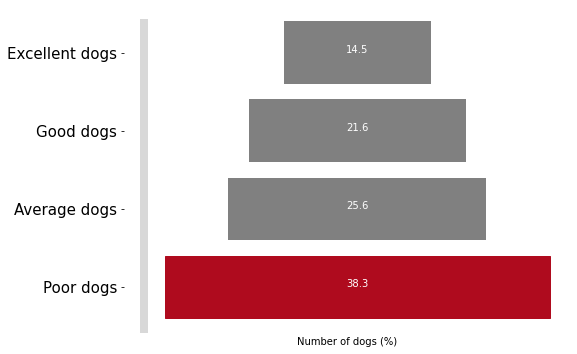

In [113]:
rg=df.rated.value_counts().reset_index().rename({"index":"rated","rated":"count"},axis=1)
rg['neg']=rg['count']*-1
rg['percent']=np.round(df.rated.value_counts(normalize=True).values*100,1)
print(50*"-")
print(rg)
print(50*"-")
fig,ax=plt.subplots(figsize=(8,6))
p=plt.barh(rg['rated'],rg['count'],color='grey',)
p1=plt.barh(rg['rated'],rg['neg'],color='grey')
# plt.bar_label(p,label_type='center',size=12,name="Verdana",alpha=0.7,padding=-50)
sns.despine(bottom=True,left=True)
for ind, val in enumerate (list(rg['percent'].sort_values(ascending=False))):
    plt.text(0,ind,val,ha='center',color='white')
ax.axvline(-700, color='grey', alpha=0.3, linewidth=8,ymax=0.95, ymin=-0.62)
ax.set_xticks([])
ax.set_xlabel("Number of dogs (%)")
ax.set_yticks(['poor','good','average','excellent'])
ax.set_yticklabels(['Poor dogs',"Average dogs","Good dogs","Excellent dogs"],size=15)
ax.set_title("",size=15)
p[0].set_color('#af0b1e')
p1[0].set_color('#af0b1e')

plt.show()



> Contrary to popular opinions about the WeRateDogs rating system, it displays a pyramidal type despite accommodating a higher numerator value than the denominator.  In other words, it has been certainly uneasy for many dogs to earn the excellent barge. This is similar to every other conventional rating system where the highest band is for a few that have demonstrated rare qualities, while the bottom pyramid is reserved for qualities below acceptable expectations.

>In the history of WeRateDogs postings, the percentage of dogs that have been accorded the excellent barge are the fewest accounting for just about 14.5% of the total, while poorly rated dogs sit at the bottom of the pyramid and they consist of the largest number so far. Poorly rated dogs constituted 38.3% of the total dogs studied

>Comments from many Twitter users suggest the public still finds it weird to reconcile their dog rating system which points us to the next question as to whether or not their Twitter engagement has been growing over the years or they have lost followers due to their system or not. A look at the association between key variables relating to a post will point us in the right direction

### Does any relationship exist between retweets, band score and like?

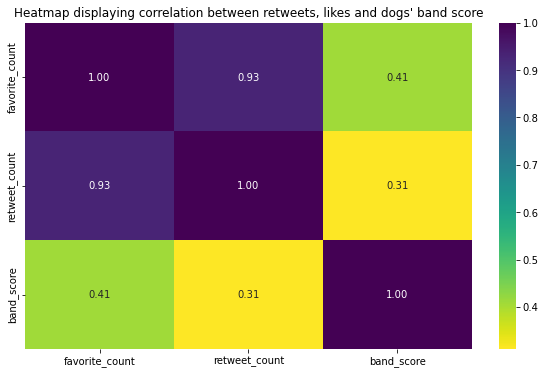

In [114]:
corr=df[['favorite_count','retweet_count','band_score']].corr()
fig,ax=plt.subplots(figsize=(10,6))
sns.heatmap(corr,annot=True,fmt='.2f',cmap='viridis_r',ax=ax)
ax.set_title("R")
plt.title('Heatmap displaying correlation between retweets, likes and dogs\' band score')
plt.show()


> Interestingly, the heatmap shows a strong positive relationship (_0.93_) between the number f retweets and favorites (Likes). Similarly, dogs' fractional rating scores correlated minimally with Retweets and Likes with correlation coefficients of 0.31 and 0.41 respectively. in other words, the association between the dogs' score and either Retweets or Likes is a weak one. 
>Although the relationship is a weak one, this might be indicating some kind of salient agreement between other Twitter users engaging with WeRateDogs' contents with their Like and Retweet buttons. 


>Before we delve in deeper, let's have a glimpse at their posts over the years.How often do they post one dog type or the other and have they been losing or engaging more Twitter users since its inception? Let's find out!

### What dog stages were posted the most?

In [115]:
df2=df[df['dog_stage']!='unclassified']
df2.dog_stage.value_counts()

pupper          166
doggo            54
puppo            22
floofer           8
doggo_pupper      6
Name: dog_stage, dtype: int64

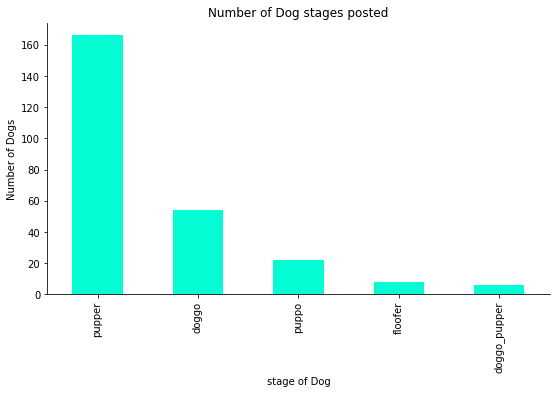

In [116]:



fig,ax=plt.subplots(1,1,figsize=(9,5))
df2.dog_stage.value_counts().plot(kind='bar',ax=ax,color='#03fcd3')
plt.title("Number of Dog stages posted")
plt.ylabel("Number of Dogs")
plt.xlabel("stage of Dog")
sns.despine()
plt.show()

>Overwhelmingly, Puppers top the list of the most number that was posted by WerateDogs. The media must have interacted with them more than the least populated floofer and doog-puppers that appeared fewer times than doggos that appeared 54 times . A doggo-pupper was captured as a result of 
the presence of the parent dog and her puppers. If we were to sort them into their various stages, Puppers will still make it to the account's top contents. 

>Beyond reasonable doubt, Puppers are Populous. Permit me to scream-__Populous Popupper__. The dominated the account's contents

>But what is special about the Puppers that they appeared 166 times as against the second place by a wide difference of 160?

> __NB:__ The unclassified group has been filtered out for clarity reasons 

### Have they been growing or losing popularity due to their weird rating system?

In [117]:
retweet=df.groupby(df.date.dt.year)["retweet_count"].mean()
fav=df.groupby(df.date.dt.year)["favorite_count"].mean()
retweet

date
2015     878.495069
2016    2188.801435
2017    4872.796178
Name: retweet_count, dtype: float64

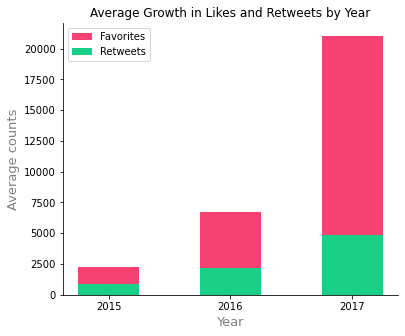

In [118]:
fig,ax=plt.subplots(figsize=(6,5))
sns.despine()
ax.bar(fav.index,fav.values,color='#f54272',width=.5,label="Favorites")
ax.bar(retweet.index,retweet.values,color='#19cf86',width=.5,label="Retweets")
ax.set_xticks(fav.index)
ax.set_xticklabels([2015,2016,2017])
ax.set_title("Average Growth in Likes and Retweets by Year")
ax.set_xlabel("Year", size=13, color='grey')
ax.set_ylabel("Average counts", size=13,color='grey')
plt.legend()
plt.show()

>Both Likes and Retweets grew steadily between 2015-2016 until 2017 that the dog rating account expreinced a surge in the number of twitter users engaging with their contents- __Active-likers*__.
>We can observe clearly that the user engagement steeped much higher after maintaining a steady growth in 2017.

>##### Questions:
> - Could it be that they have grown this much within the space of 3 years by posting __Puppers__ all the time?
>-  What is special about posting the Puppers?
> - what could have been responsible for the spike in the number of likes in 2017 alone?

> we shall soon find out!

## How well do twitter users afirm WeRateDogs rating with their Like or retweet buttons?

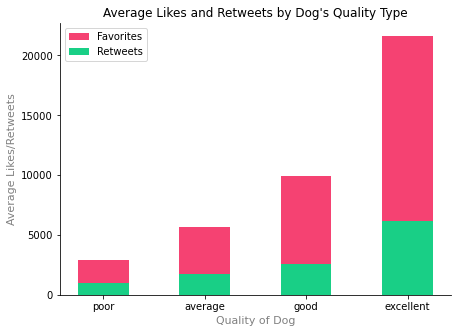

In [119]:
rt_rate=df.groupby('rated')['retweet_count'].mean()
ft_rate=df.groupby('rated')['favorite_count'].mean()

fig,ax=plt.subplots(figsize=(7,5))
sns.despine()
ax.bar(ft_rate.index,ft_rate.values,color='#f54272',width=.5,label="Favorites")
ax.bar(ft_rate.index,rt_rate.values,color='#19cf86',width=.5,label="Retweets")
ax.set_title("Average Likes and Retweets by Dog's Quality Type")
ax.set_xlabel("Quality of Dog", size=11, color='grey')
ax.set_ylabel("Average Likes/Retweets", size=11,color='grey')

plt.legend()
plt.show()

>Interesting, excellent dogs attracted the most Likes and Retweets in the period given. Again, A spike in the number of likes is noticeable.

> It would not be wrong to believe WeRateDogs social audience has a similar perception when it comes to deciding the quality of dogs that were rated

>That brings us this matra: __Excellent Dogs get more attention__, __Poor Dogs get Less attention__

> In this case, the attention is a social one.

> In addition to the question we are yet to answer, let's add this to it:_"What dog stage is poor or excellent?"_. 

>Are Puppers also the excellent ones?

## what dog stage is poor or excellent?

In [120]:
df2=df[df['dog_stage']!="unclassified"]
df3=df2.groupby(['dog_stage','rated'],as_index=False)['tweet_id'].count()
df3

,dog_stage,rated,tweet_id
0,doggo,poor,8
1,doggo,average,13
2,doggo,good,12
3,doggo,excellent,21
4,doggo_pupper,poor,0
5,doggo_pupper,average,0
6,doggo_pupper,good,5
7,doggo_pupper,excellent,1
8,floofer,poor,1
9,floofer,average,2


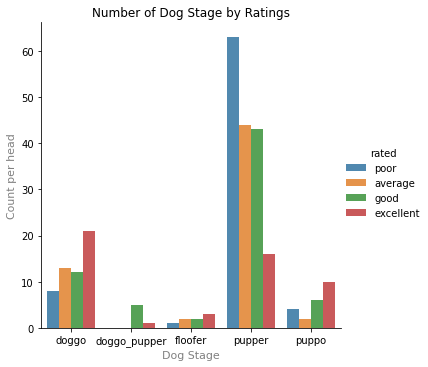

In [121]:
sns.catplot(x = "dog_stage",       # x variable name
            y = "tweet_id",       # y variable name
            hue = "rated",  # group variable name
            data = df3,     # dataframe to plot
            kind = "bar",alpha=0.85)
plt.title('Number of Dog Stage by Ratings')
plt.ylabel("Count per head",size=11,color='grey')
plt.xlabel('Dog Stage',size=11,color='grey')

plt.show()

> It can be seen that __Puppers__ rank highest in all categories except for the excellent category. doggo ranks highest in excellence followed by Puppo.

>Big shot-  __Poor Puppers__ Hmm!

>doggo_pupper are generally good dogs.  __Good doggo_pupper__

> We are beginning to see that, __Poor Puppers__ own an estate and a vast expanse of Arid land down the rating pyramid.
 
>Appollogies to Pupper owners out there. Back to the question, "What's responsible for the hike in activities of user engagement in 2017?" 



### What's responsible for the hike in interactions with WeRateDogs content in 2017?

In [122]:
hash=df.groupby('hashtag')['retweet_count'].mean()

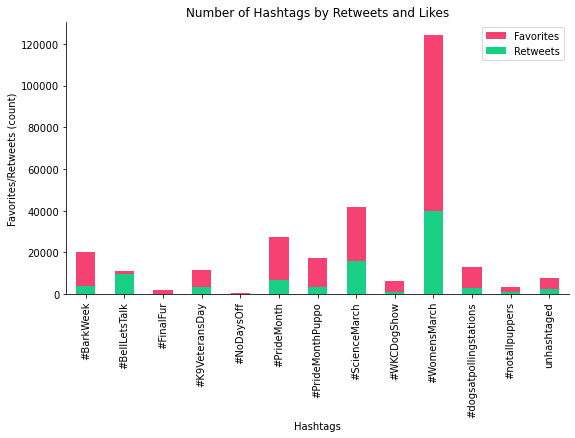

In [123]:
hash=df.groupby('hashtag')['retweet_count'].mean()

fig,ax=plt.subplots(figsize=(9,5))
df.groupby('hashtag')['favorite_count'].mean().plot(kind='bar',ax=ax,color='#f54272',label="Favorites")
df.groupby('hashtag')['retweet_count'].mean().plot(kind='bar',ax=ax,label="Retweets",color='#19cf86')
plt.title("Number of Hashtags by Retweets and Likes")
plt.ylabel("Favorites/Retweets (count)")
plt.xlabel("Hashtags")
sns.despine()

plt.legend()
plt.show()

>Interestingly, some hashtags seemed to be the vehicle for WeRateDogs. Recall, that the spike was noticeable in 2017 data. So let's do a brief check on the internet.
>### Findings:
>
>#ScienceMarch: Was an international series of rallies and marches held on Earth Day. [click to more details](https://en.wikipedia.org/wiki/March_for_Science)
> #WomensMarch: Happened in 2017. it was a single protest which has been reported to be the largest single protest in US history. [click for more details](https://en.wikipedia.org/wiki/2017_Women%27s_March)

In [124]:
df.query("hashtag=='#WomensMarch'")

,tweet_id,date,time,text,source,tweet_url,hashtag,rating_numerator,rating_denominator,dog_stage,dog_name,favorite_count,retweet_count,jpg_url,img_num,prediction,confidence_level,band_score,rated
271,822872901745569793,2017-01-21,18:26:02,Here's a super supportive puppo participating ...,Twitter for iPhone,https://t.co/nTz3FtorBc,#WomensMarch,13.0,10,puppo,unnamed,124065,39900,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,1,Lakeland_Terrier,0.196015,1.3,excellent


#### let's request for the image. It is possible it reinforces our conviction

In [125]:
url='https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg'
with open('verify.jpg','wb') as file:
    response=requests.get(url)
    file.write(response.content)

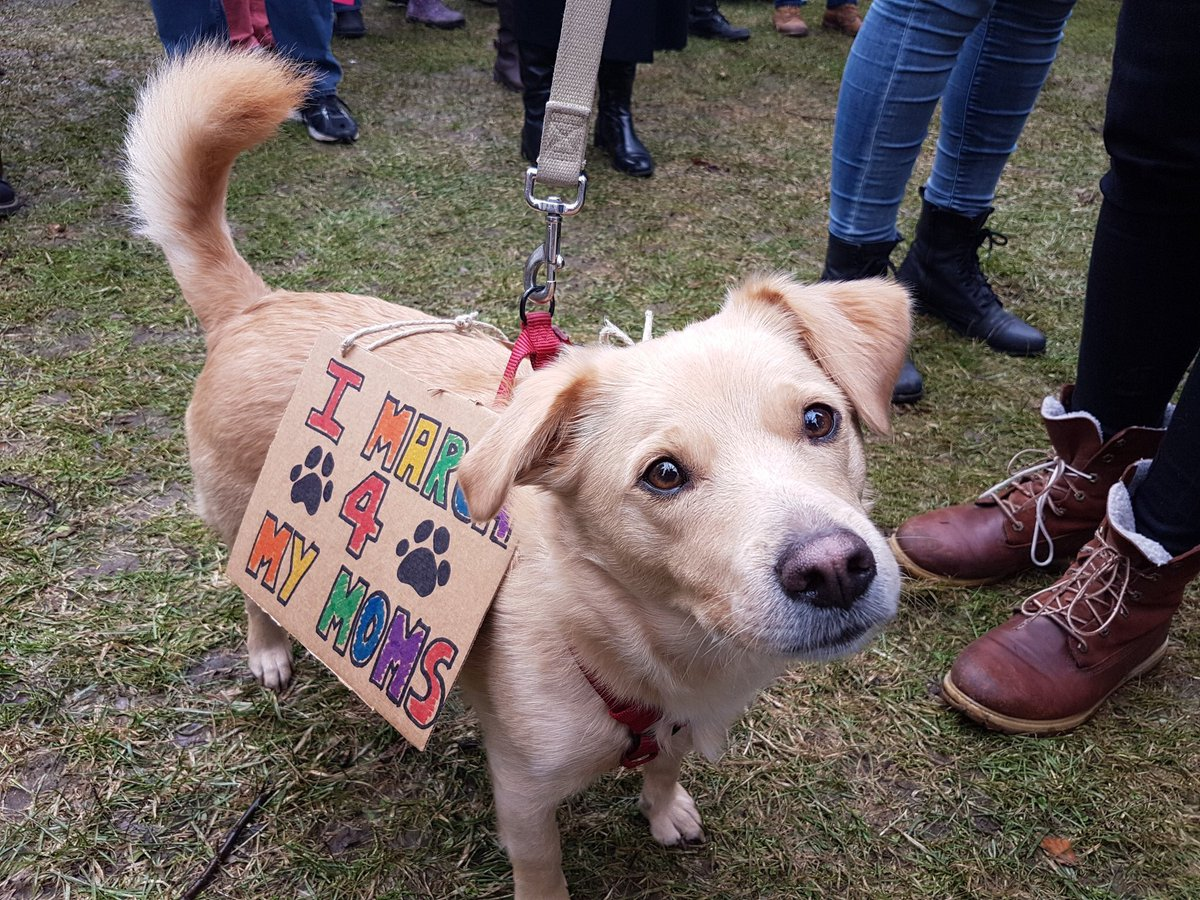

### What quality of dogs were posted on those signifcant hastag events?

In [126]:
df.groupby(['hashtag','rated'])['hashtag'].value_counts()

hashtag                 rated      hashtag               
#BarkWeek               average    #BarkWeek                   1
                        good       #BarkWeek                   1
                        excellent  #BarkWeek                   5
#BellLetsTalk           excellent  #BellLetsTalk               1
#FinalFur               average    #FinalFur                   1
#K9VeteransDay          excellent  #K9VeteransDay              1
#NoDaysOff              poor       #NoDaysOff                  1
#PrideMonth             excellent  #PrideMonth                 3
#PrideMonthPuppo        excellent  #PrideMonthPuppo            1
#ScienceMarch           excellent  #ScienceMarch               1
#WKCDogShow             excellent  #WKCDogShow                 1
#WomensMarch            excellent  #WomensMarch                1
#dogsatpollingstations  excellent  #dogsatpollingstations      1
#notallpuppers          average    #notallpuppers              1
unhashtaged             poor    

> Excellent dogs were posted almost in all cases where there was massive public engagement

### what are the top 20 Excellent breeds of dogs according to WeRateDogs?

In [127]:
df.groupby(['prediction','rated'])['band_score'].mean().sort_values(ascending=False).head(20)

prediction                  rated    
Black-And-Tan_Coonhound     excellent    1.400000
Irish_Setter                excellent    1.400000
Rottweiler                  excellent    1.350000
Bloodhound                  excellent    1.350000
Bedlington_Terrier          excellent    1.350000
Gordon_Setter               excellent    1.350000
Standard_Poodle             excellent    1.350000
Pomeranian                  excellent    1.350000
French_Bulldog              excellent    1.342857
Eskimo_Dog                  excellent    1.320000
Pembroke                    excellent    1.318182
Golden_Retriever            excellent    1.309459
Chihuahua                   excellent    1.307692
Labrador_Retriever          excellent    1.306667
Samoyed                     excellent    1.306667
Irish_Terrier               excellent    1.300000
Chesapeake_Bay_Retriever    excellent    1.300000
Greater_Swiss_Mountain_Dog  excellent    1.300000
Great_Pyrenees              excellent    1.300000
Chow        

## Conclusion

>Even though the rating system does not agree with Math theories, the WeRateDogs system could be seen as pyramidal just like every other rating system. As it is possible for a student to score "A" in mathematics or "B" in another subject, @dogs_rates also provides a system where poor dogs are placed in separate categories from the good ones. After all, they know good dogs according to the handle's reply to another verified Twitter user,Brant ["they're good dogs Brent."](http://knowyourmeme.com/memes/theyre-good-dogs-brent).

>__Puppers__ dominated the handle's posts yet they sit largely at the bottom of the scoring pyramid. It was also found that the handle rarely uses hashtags to engage the public, the major landslide surge was a result of the hashtag being a driving force and they seemed to have been selective in choosing dogs' quality that they post during certain events. They majorly posted Excellently rated dogs on those rare occasions which could have spiced up their social engagement.
Excellent __Puppo__ should be commended for her support in solidarity during the #WomenMarch, she earned more Likes and more Retweets for the handle.

>It is equally important to identify breeds of dogs with Excellent qualities in them. __Irish setter__ and __Black and tan coonhound__ were the highest-rated breeds with a band score of 1.4.

## Limitations
>There were a lot of unclassified Dog stages. Having that complete would have answered the question, "What dog stage was posted the most?" much better.


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1657 entries, 0 to 1656
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1657 non-null   object        
 1   date                1657 non-null   datetime64[ns]
 2   time                1657 non-null   object        
 3   text                1657 non-null   object        
 4   source              1657 non-null   object        
 5   tweet_url           1657 non-null   object        
 6   hashtag             1657 non-null   object        
 7   rating_numerator    1657 non-null   float64       
 8   rating_denominator  1657 non-null   int32         
 9   dog_stage           1657 non-null   object        
 10  dog_name            1657 non-null   object        
 11  favorite_count      1657 non-null   int64         
 12  retweet_count       1657 non-null   int64         
 13  jpg_url             1657 non-null   object      